Represent a sphere by central position and radius.

In [71]:
import math
import typing as tp


class Vec2:
    def __init__(self, x: float, y: float) -> None:
        self.x, self.y = x, y
        
    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.x}, {self.y})"
        
    def __add__(self, other: "Vec2") -> "Vec2":
        return Vec2(self.x + other.x, self.y + other.y)
    
    def __sub__(self, other: "Vec2") -> "Vec2":
        return Vec2(self.x - other.x, self.y - other.y)
    
    def __mul__(self, value: float) -> "Vec2":
        return Vec2(self.x * value, self.y * value)
    
    def __rmul__(self, value: float) -> "Vec2":
        return self.__mul__(value)
    
    def magsqr(self) -> float:
        return self.x * self.x + self.y * self.y

    def magnitude(self) -> float:
        return math.sqrt(self.x * self.x + self.y * self.y)
    
    def unit(self) -> 'Vec2':
        m = self.magnitude()
        if m <= 0:
            return Vec2(0.0, 0.0)
        return self * (1.0 / m)
    
    def dot(self, other: 'Vec2') -> float:
        return self.x * other.x + self.y * other.y
    
    def angle(self, other: 'Vec2') -> float:
        """Get the angle between self and other."""
        d = self.unit().dot(other.unit())
        return math.acos(d)
    
    def rotated(self, rads: float) -> 'Vec2':
        """Get self, rotated clockwise by rads."""
        cos = math.cos(rads)
        sin = math.sin(rads)
        x = self.x * cos - self.y * sin
        y = self.y * c + self.x * sin
        return Vec2(x, y)
    
    def normal(self) -> 'Vec2':
        """Get a unit Vec2 that is normal to self."""
        return Vec2(-self.y, self.x)

Represent a polygon as a sequence of line-segment edges.  For convenience, initialize it from a sequence of vertices.

In [97]:
class LineSegment:
    def __init__(self, p0: Vec2, pf: Vec2) -> None:
        self.p0, self.pf = p0, pf

    def crosses_upward(self, y: float) -> bool:
        # Is self an upward segment that crosses y?
        return self.p0.y <= y < self.pf.y
    
    def crosses_downward(self, y: float) -> bool:
        # Is self a downward segment that crosses y?
        return self.pf.y <= y < self.p0.y

    def x_intersect(self, ray_origin: Vec2) -> float:
        # Assuming self is not a horizontal line, find the x value,
        # at which a ray emanating in the positive x direction from
        # ray_origin intersects self.
        dx = self.pf.x - self.p0.x
        dy = self.pf.y - self.p0.y
        if abs(dx) < 1.0e-6:
            return ray_origin.x - 1.0  # No intersection for horizontal edges.
        dy_fract = (ray_origin.y - self.p0.y) / dy
        return self.p0.x + dy_fract * dx
    

# Special case, used to represent bounding boxes.
class Rect:
    def __init__(self, x: float, y: float, w: float, h: float) -> None:
        self.origin = Vec2(x, y)
        self.size = Vec2(w, h)
        
    def extrema(self) -> tp.Tuple[float, float, float, float]:
        return (
            self.origin.x, self.origin.y,
            self.origin.x + self.size.x, self.origin.y + self.size.y)
    
    def contains(self, p: Vec2) -> bool:
        xmin, ymin, xmax, ymax = self.extrema()
        return (xmin <= p.x < xmax) and (ymin <= p.y < ymax)


class Polygon:
    def __init__(self, vertices: tp.Iterable[Vec2]) -> None:
        v = list(vertices)
        vlen = len(v)
        self.vertices = v
        self.edges = [LineSegment(v[i], v[(i + 1) % vlen]) for i in range(vlen)]
        
    def bounding_box(self) -> Rect:
        xvals = [v.x for v in self.vertices]
        yvals = [v.y for v in self.vertices]
        
        xmin = min(x for x in xvals)
        xmax = max(x for x in xvals)
        ymin = min(y for y in yvals)
        ymax = max(y for y in yvals)
        return Rect(xmin, ymin, xmax - xmin, ymax - ymin)
    
    def contains(self, p: Vec2) -> bool:
        """Does self contain point p?"""
        # http://geomalgorithms.com/a03-_inclusion.html
        if not self.bounding_box().contains(p):
            return False
        
        x0 = p.x
        y0 = p.y
        num_crossings = 0
        for edge in self.edges:
            if edge.crosses_upward(y0) or edge.crosses_downward(y0):
                if x0 < edge.x_intersect(p):
                    num_crossings += 1
        return 0 != (num_crossings % 2)
    
    def gen_segment_normals(self) -> tp.Generator[Vec2, None, None]:
        vertices = self.vertices
        num_vertices = len(vertices)
        EPS = 1.0e-6
        for i, v0 in enumerate(vertices):
            vf = vertices[(i + 1) % num_vertices]
            dy = vf.y - v0.y
            dx = vf.x - v0.x
            # The polygon's last point is the same as its first,
            # just to close the shape.  That means there may be no "line"
            # between last and first vertices.
            if (abs(dx) > EPS) and (abs(dy) > EPS):
                yield Vec2(-dy, dx)
            
    def get_dot_product_extrema(self, normal: Vec2) -> tp.Tuple[float, float]:
        vmin: tp.Optional[float] = None
        vmax: tp.Optional[float] = None
        for v in self.vertices:
            dot = v.dot(normal)
            if vmin is None:
                vmin = vmax = dot
            else:
                if vmin > dot:
                    vmin = dot
                if vmax < dot:
                    vmax = dot
        return (vmin, vmax)
    
    def get_nearest_vertex(self, point: Vec2) -> Vec2:
        """Get the vertex of self that's nearest to point."""
        result = None
        min_mag = None
        for i, vertex in enumerate(self.vertices):
            dsqr = (vertex - point).magsqr()
            if (i == 0) or (min_mag > dsqr):
                result = vertex
                min_mag = dsqr
        return result


In [98]:
class Sphere:
    def __init__(self, x: float, y: float, r: float) -> None:
        self.center = Vec2(x, y)
        self.radius = r

    def get_dot_product_extrema(self, normal: Vec2) -> tp.Tuple[float, float]:
        # Need to generate two vectors representing self's center-minus-radius,
        # and center-plus-radius, along the normal (projection) vector.
        center_dot = self.center.dot(normal)
        # No matter which way you shine the light, the min and max should offset from
        # the center by one radius.
        return (center_dot - self.radius, center_dot + self.radius)


In [99]:
vertices = [Vec2(x * 10.0, y * 10.0) for (x, y) in [
    [0.0, 0.0],
    [0.02, 0.03],
    [0.04275, 0.05],
    [0.1, 0.07],
    [0.175, 0.087],
    [0.25, 0.09],
    [0.425, 0.07],
    [1.0, -0.07],
    [0.5, -0.055],
    [0.125, -0.035],
    [0.04275, -0.03],
    [0.02, -0.02],
    [0.0, 0.0]
]]

poly = Polygon(vertices)

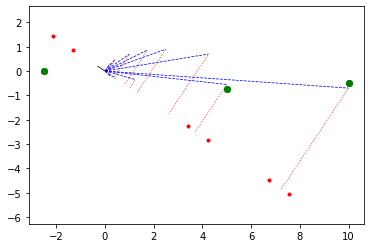

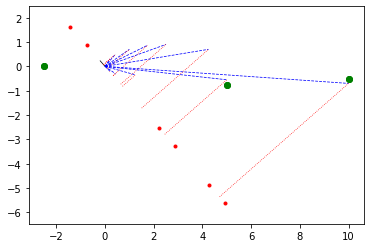

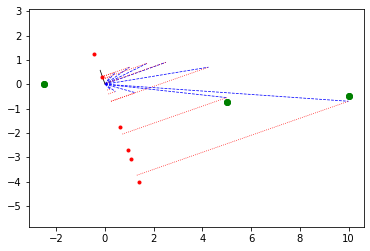

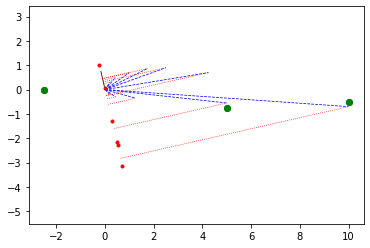

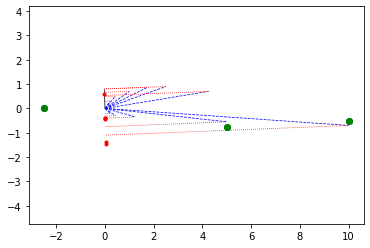

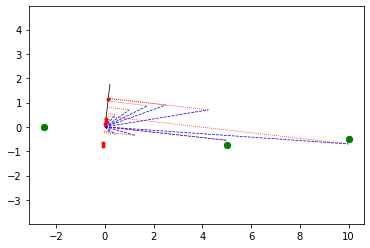

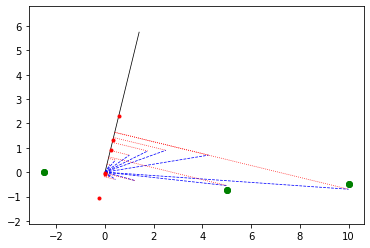

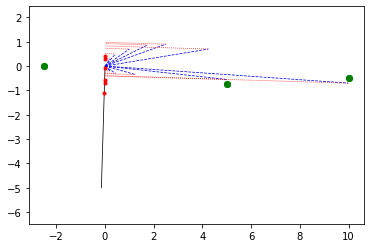

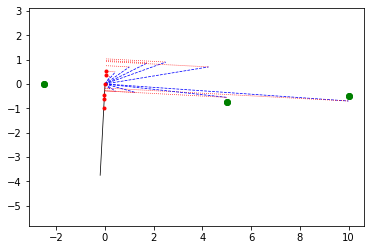

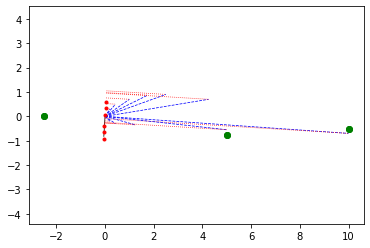

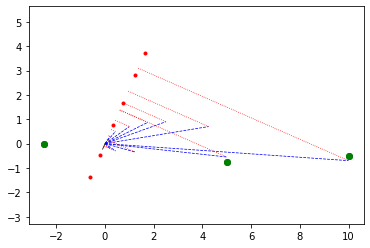

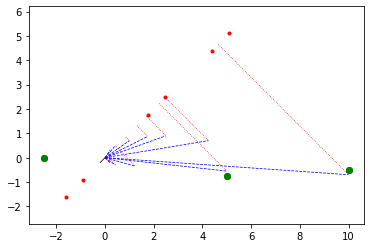

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

# Some dummy 'particles':
particles = [
    Sphere(x * 10.0, y * 10.0, 0.5) for (x, y) in [
        [-0.25, 0.0],
        [0.5, -0.075],
        [1.0, -0.05],
    ]
]

assert (len(vertices) - 1) == len(list(poly.gen_segment_normals()))

for normal in poly.gen_segment_normals():
    fig = plt.figure()
    plt.axis('equal')
    lw = 0.75
    plt.plot([0, normal.x], [0, normal.y], "k-", linewidth=lw)
    unormal = normal.unit()
    for vertex in poly.vertices:
        dot = vertex.dot(unormal)
        plt.plot([0, vertex.x], [0, vertex.y], "b--", linewidth=lw)
        # How to plot the magnitude of the dot product, along the normal?
        vdot = dot * unormal
        plt.plot([vdot.x, vertex.x], [vdot.y, vertex.y], "r:", linewidth=lw)
    
    for particle in particles:
        for dot in particle.get_dot_product_extrema(unormal):
            vdot = dot * unormal
            plt.plot([vdot.x], [vdot.y], "r.", linewidth=particle.radius)
            plt.plot([particle.center.x], [particle.center.y], "go", linewidth=particle.radius)
        
    # Hm... When one of your vertices is at (0, 0) you'll have trouble computing
    # a meaningful normal...


Try to implement a variation of the Separating Axis Theorem.

In [105]:
class SATCollisioner:
    def __init__(self, s: Sphere, p: Polygon) -> None:
        self.s = s
        self.p = p
        
    def colliding(self) -> bool:
        for normal in self.p.gen_segment_normals():
            if not self._overlaps_with_normal(normal):
                return False
        # How to check all of the orientations of the sphere?
        # The SAT tutorial suggests using the axis from the sphere center to
        # the nearest polygon vertex.  This seems perfectly obvious once you
        # visualize it.
        center = self.s.center
        pnearest = self.p.get_nearest_vertex(center)
        normal = (pnearest - center).normal()
        return self._overlaps_with_normal(normal)
    
    def _overlaps_with_normal(self, normal: Vec2) -> bool:
        unormal = normal.unit()
        pmin, pmax = self.p.get_dot_product_extrema(unormal)
        smin, smax = self.s.get_dot_product_extrema(unormal)
        return (smin < pmax) and (smax > pmin)


        
for (sx, expected) in [
    [-0.5, False], 
    [0.0, True],
    [1.0, True],
    [1.1, False],
]:
    sphere = Sphere(sx * 10.0, 0.0, 1.0)
    coller = SATCollisioner(sphere, poly)
    actual = coller.colliding()
    print(f"({sx}, 0) expected {expected}, got {actual}")

(-0.5, 0) expected False, got False
(0.0, 0) expected True, got True
(1.0, 0) expected True, got True
(1.1, 0) expected False, got False
